<img src="./images/iride.png" alt="iride_logo" width="200" height="200" style="float: right;  margin-right: 60px;" />

## Time Series statistics  on Air Quality model output 

<div style="background-color: #e6f7ff; padding: 10px;">
    <p style="color: #3366cc;">How to compute statistics (minimum, maximum and average) on single point time series and the plot visualization for a specific dataset in the Adam catalogue, in this case applied to the Air Quality model output provided by ARPAE, by using searching and filtering functionalities provided through the API. </p>
</div>


#### Introduction
<br>
This notebook shows how to implement an advanced search operation for a specific dataset, by using the functionalities provided in the Adam API, by defining a search operation using the filters enabled for a dataset selected in the catalogue.
It extracts minimum, maximum and average  values from a time series, by using searching and filtering functionalities provided through the Adam API
This notebook shows how to implement an advanced search operation for a specific dataset, by using the functionalities provided in the Adam API, by defining a search operation using the filters enabled for a dataset selected in the catalogue.
<br>
The notebook then downloads the specified dataset data of a time series from a certain point, writes the data into a csv file and then computes minimum, maximum, and average values of the time series and displays them.

The user can specify the following parameters:
- User API-Key, that can be found after the login into the specified URL (Step 1)
- Spatial domain: the single point of interest in GeoJSON format (Step 2)
- Temporal domain: the time range (Step 2)

#### Outline 
- [Step 1: Authentication](#section1)
- [Step 2: Dataset and Data Discovery](#section2)
- [Step 3: Compute min/max/avg of the time series (of a single point) and plot data](#section3)

<br>

To install and load the required libraries it is recommended to create a Python virtual environment; for **adamapi** you can follow this guide: https://pypi.org/project/adamapi/

**Note**: the numpy dependency used by pandas is not compatible with the one used by adamapi, so in this notebook pandas is not used

In [1]:
from adamapi import Auth, Datasets, Search, GetData
from IPython.display import clear_output
import colorama
from colorama import Fore, Style

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter, AutoDateLocator, DateLocator
from datetime import datetime
# import pandas as pd 

<a id="section1"></a>
### Step 1: Authentication

The following lines of code will show how to use the personal Adam API-Key with the endpoint currently in use, to get access for the datasets in the related catalogue. At the end of the execution, if the authentication process is successfull the personal token and the expiration time should be returned as outputs.

The API-Key can be found after the login into the URL


<img src="./images/login.png" alt="login" />

In [9]:
API_Key = input('Type your Adam API Key : ')
clear_output(wait=True)
Endpoint_URL = input('Type the URL for the selected endpoint : ')
clear_output(wait=True)
a=Auth()
a.setKey(API_Key)
a.setAdamCore(Endpoint_URL)
a.authorize()
# a.getAuthToken()

{'access_token': '0c14e4f39a41f3b039617452c252e88a',
 'refresh_token': '4f666ee8ef8da14dec89529dd6cc6447',
 'expires_at': '2023-11-20T16:45:15.464Z',
 'expires_in': 3600}

<a id="section2"></a>
### Step 2: Dataset and Data Discovery, and extraction of data 

Each dataset in the catalogue can have a list of filters allowing a refined search operation that select the products according to parameters that go beyond the standard spatial and temporal constraints. The enabled filters, for any of the available datasets, are listed in the metadata of a dataset.

In [3]:
datasets=Datasets(a)
data=GetData(a)

try:
    datasets.getDatasets()
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")
else:
    print("successful")

prod_list = datasets.getDatasets()

total = prod_list['properties']['totalResults']
items = prod_list['properties']['itemsPerPage']
pages = total//items

print(Style.BRIGHT + Fore.BLUE + '\033[1m' + 'Number of available datasets:', total)

print(Fore.RED + '\033[1m' + 'List of available datasets:')


print('----------------------------------------------------------------------')

print ('\033[0m')

i=0
while True:
            page = datasets.getDatasets(startIndex = i)['features']
            if len(page)==0:
                break
            print(Style.BRIGHT + Fore.BLUE + '\033[1m' + 'Page ', int(i/10))
            print('')
            for element in page:
                print(Style.BRIGHT + Fore.RED + element['title'] + Fore.BLACK + "\033[1m" + " --> datasetId "+ "\033[0m" + "= " + element['datasetId'])
            i+=10
            print('')

successful
Number of available datasets: 9
List of available datasets:
----------------------------------------------------------------------

Page  0

ARPAE Air quality: NO2 --> datasetId = 6544b70a14ecf9c6d835831b:ARPAE_2D_NO2
ARPAE Air quality: PM10 --> datasetId = 6544b70914ecf9c6d83582f7:ARPAE_2D_PM10
ARPAE Air quality: PM2.5 --> datasetId = 6544b70a14ecf9c6d835830c:ARPAE_2D_PM25
ENEA AQ models: NO2 --> datasetId = 65251d0b14ecf9c6d82d8918:FARM_conc_g2_NO2
Sentinel-3: Aerosol Optical Depth --> datasetId = 65251d5214ecf9c6d82de256:S3B_SL_2_AOD_550
Sentinel-3: Aerosol Optical Depth QA --> datasetId = 65251d5214ecf9c6d82de268:S3B_SL_2_AOD_quality_flags
Sentinel-5P OFFL: O3 Total Vertical Column --> datasetId = 652518d414ecf9c6d82d0b91:S5P_OFFL_L2_O3_PRODUCT_ozone_total_vertical_column
Sentinel-5P OFFL: O3 quality assurance --> datasetId = 652518d414ecf9c6d82d0b7e:S5P_OFFL_L2_O3_qa_value
S&T Air Quality Index: daily average --> datasetId = 653f965814ecf9c6d8353a48:processed_aqi_avg_da

You can choose to download data from a sigle dataset or from a list of datasets

In [4]:
datasetID='6544b70a14ecf9c6d835831b:ARPAE_2D_NO2'
datasetIDlist = ['6544b70a14ecf9c6d835831b:ARPAE_2D_NO2', '6544b70914ecf9c6d83582f7:ARPAE_2D_PM10', '6544b70a14ecf9c6d835830c:ARPAE_2D_PM25']

In [5]:
#-----spatial domain------
geom = '{"type":"Point","coordinates":[11.1970407369318,45.0293271900268]}'

#-----temporal domain-------
start_date = '2020-12-27'
end_date = '2021-01-01'

In [6]:
search = Search(a)
maxRecords = 5
results = search.getProducts(
    datasetID, 
    geometry= geom,
    startDate = start_date,
    endDate = end_date,
    maxRecords = maxRecords
 )

total = results['properties']['totalResults']
print(total)
print(Fore.BLUE + 'Number of available products: ' + str( results['properties']['totalResults']))
if total>maxRecords:
    print('\033[1m' + 'List of the ' + str(maxRecords)+ ' most recent products of '+ Style.BRIGHT + Fore.RED + datasetID.split(':')[1] )
else:
    print('\033[1m' + 'List of the ' + str(total)+ ' most recent products of '+ Style.BRIGHT + Fore.RED +  datasetID.split(':')[1] )
print ('\033[0m')
count = 1
for i in results['features']:


    print("\033[1;31;1m" + '-----------------------------------------------')
    print("\033[1;31;1m" + "#" + str(count))
    print ('\033[0m')
    print(Style.BRIGHT + Fore.BLACK + 'product Date: ' + Fore.GREEN + i['productDate'])
    print(Style.BRIGHT + Fore.BLACK + 'product Id: ' + Fore.GREEN + i['productId'])
    count = count+1

120
Number of available products: 120
List of the 5 most recent products of ARPAE_2D_NO2

-----------------------------------------------
#1

product Date: 2020-12-31T23:00:00Z
product Id: ARPAE_2D_NO2_20201231230000.tif
-----------------------------------------------
#2

product Date: 2020-12-31T22:00:00Z
product Id: ARPAE_2D_NO2_20201231220000.tif
-----------------------------------------------
#3

product Date: 2020-12-31T21:00:00Z
product Id: ARPAE_2D_NO2_20201231210000.tif
-----------------------------------------------
#4

product Date: 2020-12-31T20:00:00Z
product Id: ARPAE_2D_NO2_20201231200000.tif
-----------------------------------------------
#5

product Date: 2020-12-31T19:00:00Z
product Id: ARPAE_2D_NO2_20201231190000.tif


The filters have to be in JSON format:

In [7]:
filters = {
    "startDate":start_date,
    "endDate":end_date,
    "geometry":geom
}

The **adamapi** saves the files by default in the folder "adamapiresults"

In [8]:
for index, dataset_id in enumerate(datasetIDlist):
    print(dataset_id)
    ts = data.getData(
        datasetIDlist[index],
        "GetTimeseries",
        asynchronous=False,
        compress=False,
        rest=False,
        filters = filters,
        options={"format":'csv'},
        outputDir=datasetIDlist[index].split(':')[1]
    )

6544b70a14ecf9c6d835831b:ARPAE_2D_NO2


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


6544b70914ecf9c6d83582f7:ARPAE_2D_PM10


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.67it/s]


6544b70a14ecf9c6d835830c:ARPAE_2D_PM25


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


The function **extract_data** reads each the csv files in **folder_path**, extracts date and value and writes them into a single csv sorted by date of acquisition. In this way we can have a single csv file containing the entire time series for a specific dataset.

In [164]:
def extract_data(folder_path, output_csv_path):
    # List to store extracted data
    consolidated_data = []
    
    # Loop through each CSV file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            # Construct the full path to the CSV file
            file_path = os.path.join(folder_path, filename)
            
            # Open the CSV file and read its content
            with open(file_path, 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                
                # Assuming the first row contains headers
                headers = next(csv_reader)
                
                # Find the indices of 'Date' and 'Value' columns
                date_index = headers.index('date')
                value_index = headers.index('value')
                
                # Loop through each row and extract 'Date' and 'Value'
                for row in csv_reader:
                    date = row[date_index]
                    value = row[value_index]
                    extracted_value = float(value.strip('[]').replace('[', '').replace(']', ''))
                    
                    # Append the extracted data to the list
                    consolidated_data.append({'date': date, 'value': extracted_value})
    
    # sort by date of acquisition
    consolidated_data.sort(key=lambda x: x['date'])
    
    # Write the consolidated data to a new CSV file
    with open(output_csv_path, 'w', newline='') as output_csv_file:
        # Define the CSV writer
        csv_writer = csv.DictWriter(output_csv_file, fieldnames=['date', 'value'])
        
        # Write headers
        csv_writer.writeheader()
        
        # Write the data
        csv_writer.writerows(consolidated_data)


<a id="section3"></a>
### Step 3: Compute minimum, maximum and average of the time series (of a single point) and plot data
The function **read_csv** reads the csv written in the prevoius step and returns a numpy array containing the time series values and a variable time, representing the days of the acquisition. 

The function **compute_statistics** computes minimum, maximum and average value of the time series, using the functions from the numpy library.

In [170]:
def read_csv(file_path, column_name):
    time_series_data = []
    time = []
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            time_series_data.append(float(row['value']))
            time.append(row['date'])
    return np.array(time_series_data), time

In [171]:
def compute_statistics(time_series_data):
    min_value = np.min(time_series_data)
    max_value = np.max(time_series_data)
    avg_value = np.mean(time_series_data)
    return min_value, max_value, avg_value

Now for each dataset:
- Read the csv file
- Compute the different statistics and print them
- Plot the time series and the statistics
- (Optional) Plot all the time series in the same plot

Dataset: ARPAE_2D_NO2
Minimum value: 4.155827045440674
Maximum value: 40.5927734375
Average value: 19.807188526789346



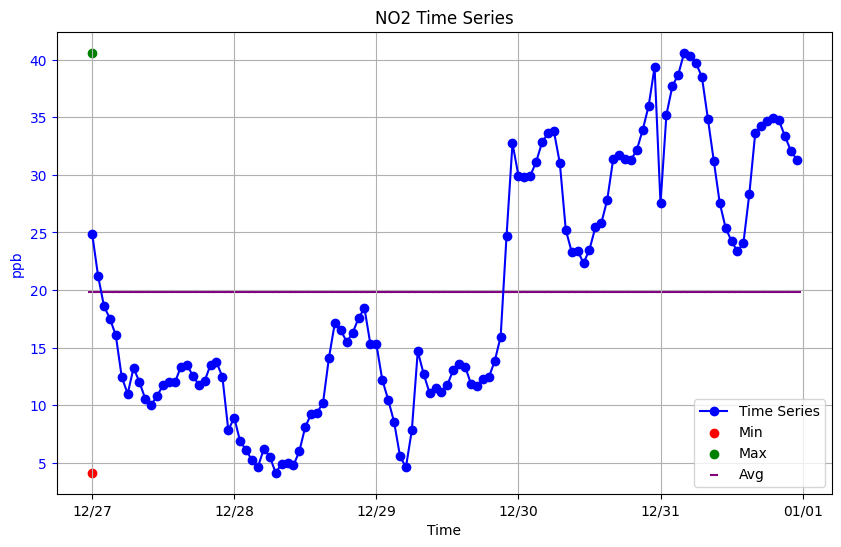


Dataset: ARPAE_2D_PM10
Minimum value: 8.205906867980957
Maximum value: 74.65577697753906
Average value: 39.795586959520975



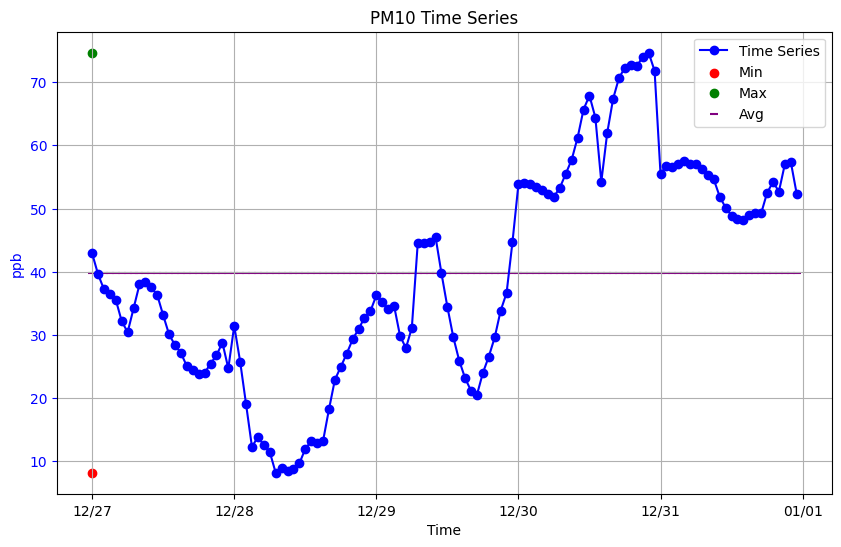


Dataset: ARPAE_2D_PM25
Minimum value: 7.799008846282959
Maximum value: 74.00541687011719
Average value: 39.18035519520442



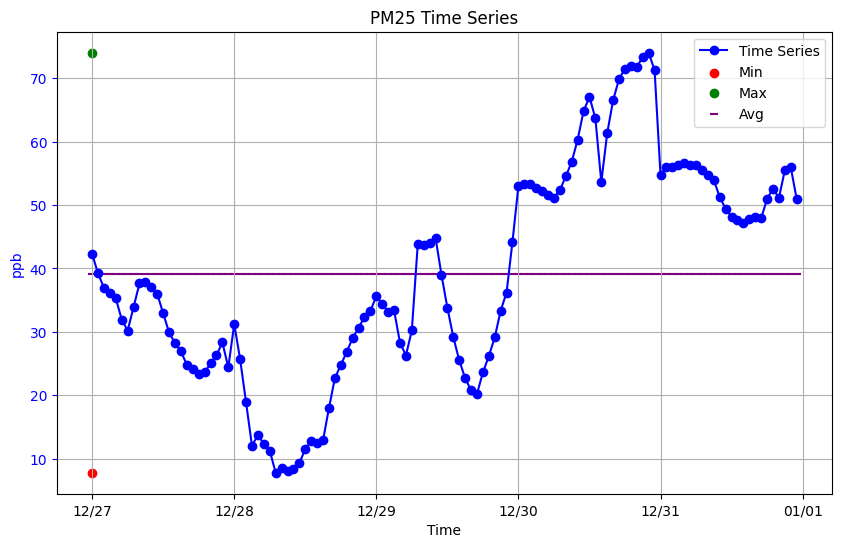

In [200]:
for index, dataset_id in enumerate(datasetIDlist):
    dataset = datasetIDlist[index].split(':')[1]
    
    in_path = f'/adamapiresult/{dataset}/'
    out_path = f'/{dataset}_ts.csv'
    extract_data(in_path, out_path)

    time_series_data, time = read_csv(out_path, 'value')    
    dates = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ") for t in time]
    unique_dates = sorted(set(date.date() for date in dates))  # Extract unique dates and sort them
    min_value, max_value, avg_value = compute_statistics(time_series_data)

    print(f"Dataset: {dataset}")
    print(f"Minimum value: {min_value}")
    print(f"Maximum value: {max_value}")
    print(f"Average value: {avg_value}")
    print("")

    parts = dataset.split('_')
    title = parts[-1]

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the time series
    ax.plot(dates, time_series_data, label='Time Series', color='blue', marker='o')
    
    # Plot statistics as points
    # Plot statistics as points with different colors
    ax.scatter(dates[0], min_value, color='red', marker='o', label='Min')
    ax.scatter(dates[0],  max_value, color='green', marker='o', label='Max')
    ax.scatter(dates, [avg_value] * len(time), color='purple', marker='_', label='Avg')
    
    ax.grid(True)
    
    # Format x-axis labels to show only the days
    ax.xaxis.set_major_locator(plt.MaxNLocator(len(unique_dates)+1))  # Set the number of ticks to the number of unique dates
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    
    # Adding labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('ppb', color='blue')
    ax.tick_params('y', colors='blue')
    ax.legend()
    
    # Show the plot
    plt.title(f'{title} Time Series')
    plt.show()

    print("")

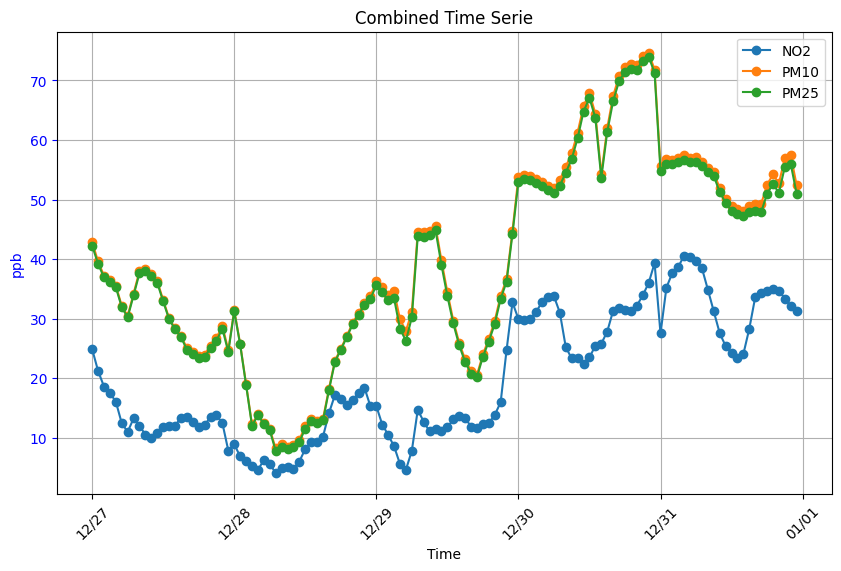

In [202]:
# Create a figure
fig, ax = plt.subplots(figsize=(8, 4))

# Assuming datasetIDlist is a list of dataset IDs
for dataset_id in datasetIDlist:
    dataset = dataset_id.split(':')[1]

    in_path = f'/adamapiresult/{dataset}/'
    out_path = f'/{dataset}_ts.csv'
    extract_data(in_path, out_path)

    time_series_data, time = read_csv(out_path, 'value')
    dates = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ") for t in time]
    unique_dates = sorted(set(date.date() for date in dates))  # Extract unique dates and sort them
    min_value, max_value, avg_value = compute_statistics(time_series_data)

    parts = dataset.split('_')
    title = parts[-1]

    # Plot the time series with different colors
    ax.plot(dates, time_series_data, label=f'{title}', marker='o')

# Customize the plot
ax.grid(True)

# Format x-axis labels to show only the days
ax.xaxis.set_major_locator(plt.MaxNLocator(len(unique_dates)+1))  # Set the number of ticks to the number of unique dates
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

# Adding labels and title
ax.set_xlabel('Time')
ax.set_ylabel('ppb', color='blue')
ax.tick_params('y', colors='blue')
ax.legend()
plt.title('Combined Time Series')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()